## 0. Link Prediction

link prediction aims to predict the incidence between arbitrary node pairs.

About the dataset for link prediction, we can directly construct it from the dataset used for node classification tasks. For example, the commonly used Cora dataset can be utilized by ignoring its node labels and treating the edges within the Cora graph as training/testing data. Now, let's go through the specific implementation.

In [1]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

/home/kit/aifb/cc7738/anaconda3/envs/subgraph-text/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# preprocessing in pyg in implemented in transform module
transform = T.Compose([
    T.NormalizeFeatures(),  # normalize 
    T.ToDevice(device),    # config the device
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,  # create the train/val/test split default 0.85/0.05/0.1/
                      split_labels=True, add_negative_train_samples=False),])


dataset = Planetoid('./', name='Cora', transform=transform)
train_data, val_data, test_data = dataset[0]

Firstly let's get some intuition about the citation network：
* we dont use y(label for the node), train_mask, val_mask, test_mask；these are split mask for node classification task, please ignore them. 
* pos_edge_label_index are index for the positive samples，pos_edge_label is their labels (all 1)
* neg_edge_label_index are index for the negative samples，neg_edge_label is their labels (all 0)

In [3]:
train_data

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[4488], pos_edge_label_index=[2, 4488])

In [4]:
train_data.pos_edge_label, train_data.pos_edge_label_index

(tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 tensor([[1498,  364, 1469,  ..., 1782, 1738, 1087],
         [2025, 1358, 2358,  ..., 1798, 2365, 2434]]))

In [5]:
val_data

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[263], pos_edge_label_index=[2, 263], neg_edge_label=[263], neg_edge_label_index=[2, 263])

In [6]:
val_data.neg_edge_label

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [7]:
test_data 

Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[527], pos_edge_label_index=[2, 527], neg_edge_label=[527], neg_edge_label_index=[2, 527])

*Please pay attention to*

* The `train_data` does not come with predefined negative edge samples (`neg_edge_label_index`) because we will sample negative examples during the training process.
* The graphs inside `train_data` and `val_data` are the same (having the same `edge_index`), but their positive edge samples (`pos_edge_label_index`) and negative edge samples (`neg_edge_label_index`) are different. It can be observed that there are 4488 positive edge samples in `train_data`, while `val_data` only has 263 positive edge samples (the ratio between them is 85:5).
* The graph in `test_data` is different from the one in `train_data`. It can be seen that the `edge_index` in `test_data` has more entries (an additional 527), which corresponds to the number of positive edge samples in `test_data`.

# Visualization 
the best way to visualize the graph is to use networkx here. 

In [8]:
def visual_degree(G):
  degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
  dmax = max(degree_sequence)

  fig = plt.figure("Degree of a random graph", figsize=(8, 8))
  # Create a gridspec for adding subplots of different sizes
  axgrid = fig.add_gridspec(5, 4)

  ax0 = fig.add_subplot(axgrid[0:3, :])
  Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
  pos = nx.spring_layout(Gcc, seed=10396953)
  nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
  nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
  ax0.set_title("Connected components of G")
  ax0.set_axis_off()

  ax1 = fig.add_subplot(axgrid[3:, :2])
  ax1.plot(degree_sequence, "b-", marker="o")
  ax1.set_title("Degree Rank Plot")
  ax1.set_ylabel("Degree")
  ax1.set_xlabel("Rank")

  ax2 = fig.add_subplot(axgrid[3:, 2:])
  ax2.bar(*np.unique(degree_sequence, return_counts=True))
  ax2.set_title("Degree histogram")
  ax2.set_xlabel("Degree")
  ax2.set_ylabel("# of Nodes")

  fig.tight_layout()
  plt.show()

In [9]:
data_name = "cora"
if data_name in ['cora', 'citeseer', 'pubmed']:
    dataset = Planetoid(root='./dataset', name=data_name)
    
data = dataset[0]
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

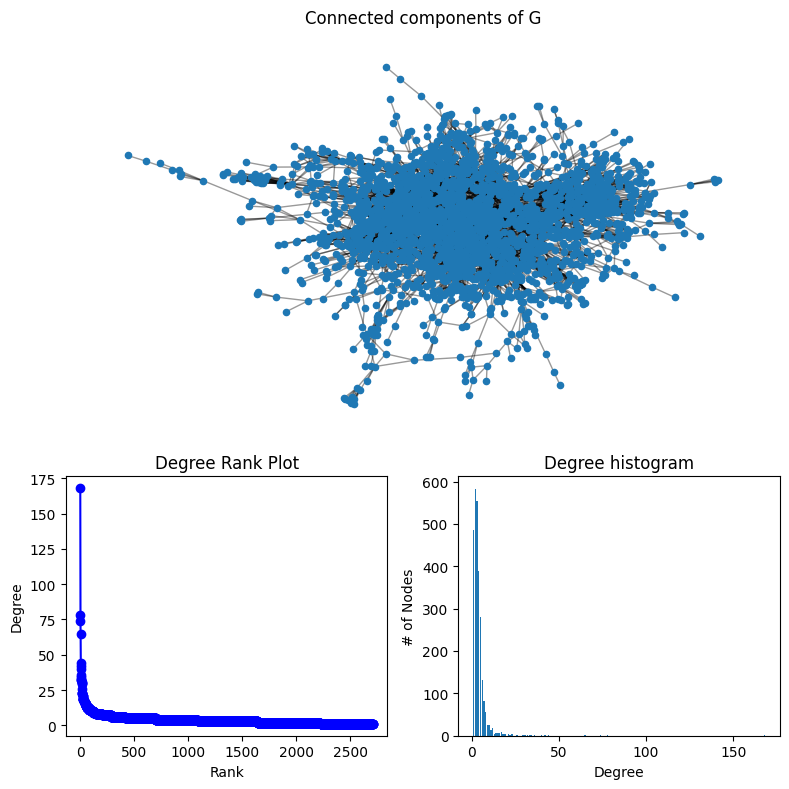

In [10]:
visual_degree(g)

## 1. Autoencoder Framework

It consists of two components: an encoder and a decoder. The encoder we commonly used is GCN (Graph Convolutional Network), while the decoder typically employs an inner product or shadow neural network. The output of the result is used as the probability of an edge existing between the two nodes. It is also believed to be the earliest work for link prediction in representation learning manner. [Here](https://arxiv.org/pdf/1611.07308.pdf)
If you find my implementation is not convincing, feel free to improve and send me one Email. 

In [11]:
from torch_geometric.nn import GCNConv

As for example, we build one two-layer GCNs as a embedder.

In [12]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        """GCN encoder with 2 layers
        in channels: number of input features of node (dimension of node feature)
        out channels: number of output features of node (dimension of node embedding)
        """
        # your code here
        

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

The range of edge label is [0, 1], it means the output of the decoder must be the same, it implies the probibility of existence of the edge between two nodes. 

In [13]:
class InnerProductDecoder(torch.nn.Module):
    
    def forward(self, z, edge_index, sigmoid=True):
        """
        parames:
        z: [num_nodes, num_feature] node embedding
        edge_index: [2, num_edges] index of node pairs
        """
        # todo your code here 
        # refer to equation 4 in the paper
        # return value in [num_edges, 1]
        value = 0
        return torch.sigmoid(value) if sigmoid else value

In [14]:
class GAE(torch.nn.Module):
    """graph auto encoder。
    """
    def __init__(self, encoder, decoder=None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder()

    def encode(self, *args, **kwargs): 
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs):
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        """In this script we use the binary cross entropy loss function.
        
        params
        ----
        z: output of encoder
        pos_edge_index: positive edge index
        neg_edge_index: negative edge index
        """
        EPS = 1e-15 # prevent log(0)
        # positive loss log()
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index) + EPS).mean() # loss for positive samples

        if neg_edge_index is None:
            neg_edge_index = torch_geometric.utils.negative_sampling(pos_edge_index, z.size(0)) # negative sampling
        neg_loss = -torch.log(
            1 - self.decoder(z, neg_edge_index) + EPS).mean() # loss for negative samples

        return pos_loss + neg_loss

In [15]:
in_channels, out_channels = dataset.num_features, 16
model = GAE(GCNEncoder(in_channels, out_channels))

In [16]:
latent = model.encode(train_data.x, train_data.edge_index)
latent, latent.shape

(tensor([[-0.0082,  0.0021, -0.0008,  ..., -0.0009,  0.0018, -0.0007],
         [-0.0006,  0.0037, -0.0061,  ...,  0.0007, -0.0002,  0.0037],
         [-0.0013,  0.0036, -0.0055,  ..., -0.0003,  0.0022, -0.0003],
         ...,
         [ 0.0017,  0.0044, -0.0052,  ..., -0.0007,  0.0011,  0.0093],
         [-0.0037,  0.0021, -0.0054,  ...,  0.0026, -0.0004,  0.0053],
         [-0.0047,  0.0016, -0.0049,  ...,  0.0021, -0.0005,  0.0031]],
        grad_fn=<AddBackward0>),
 torch.Size([2708, 16]))

In [17]:
model.decode(latent, train_data.edge_index)

tensor([0.5000, 0.5002, 0.5000,  ..., 0.5001, 0.5000, 0.5000],
       grad_fn=<SigmoidBackward0>)

## 2. Variational Autoencoder

Variational auto-encoders and auto-encoders have the same basic structure, an encoder plus a decoder. Their main difference is that the hidden layer representation encoded by the variational auto-encoder is no longer a continuous vector representation, but is instead represented by a Gaussian distribution. Specifically, the variational autoencoder learns the mean (denoted below by the variable `mu`) and standard deviation (denoted below by the variable `std`) of this Gaussian distribution.

In [18]:
MAX_LOGSTD = 10

class VariationalGCNEncoder(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = # your code, one layer GCN 
        self.conv_mu =  # your code, one layer GCN 
        self.conv_logstd =  # your code, one layer GCN  

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
    
class VGAE(GAE): 
    """inhert GAE class, since we need to use encode, decode and loss
    """
    
    def __init__(self, encoder, decoder=None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs):
        """encoder"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs) # mu stad stands for distribution for mean and std
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD) # upper bound of logstd
        z = self.reparametrize(self.__mu__, self.__logstd__) # reparameterization trick 
        return z

    def kl_loss(self, mu=None, logstd=None):
        """We add a prior of (0, I) Gaussian variables to the distribution of the hidden variables, 
        i.e., we want the distribution of the hidden variables to obey a (0, I) Gaussian distribution 
        The difference between these two distributions is measured by the KL loss."""
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1)) # KL loss between gaussian distribution and hidden variables    


(The formula for the kl loss of two Gaussian distributions can be found in this [link](https://stats.stackexchange.com/questions/234757/how-to-use-kullback-leibler-divergence-if-mean-and-standard-deviation-of-two))

In [19]:
model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
model = model.to(device)

In [20]:
latent = model.encode(train_data.x, train_data.edge_index)
latent, latent.shape

(tensor([[ 1.3589,  0.6036,  0.2877,  ..., -0.8178,  0.5317, -0.9522],
         [-0.3084,  1.4721,  0.0476,  ..., -0.0495,  0.7262,  1.8298],
         [ 0.4678, -0.4474, -0.6182,  ..., -0.1357,  0.4418, -0.5172],
         ...,
         [-0.2514,  1.6415,  0.7308,  ..., -0.8060,  0.4171, -0.2045],
         [ 1.6264, -0.6929,  0.4854,  ...,  0.3278,  0.0551,  0.0813],
         [ 0.2697,  0.1250,  1.7250,  ..., -1.0808, -1.1049,  0.6128]],
        grad_fn=<AddBackward0>),
 torch.Size([2708, 16]))

In [21]:
model.decode(latent, train_data.edge_index)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 3. Train VAE and AE

train script for VAE and GAE 

In [22]:
def train_gae(model):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return loss.item()

def train_vgae(model):
    """Training the VGAE model, the loss function consists of reconstruction loss and kl loss"""
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    loss = loss + (1 / train_data.num_nodes) * model.kl_loss() # 加上kl loss
    loss.backward()
    optimizer.step()
    return loss.item()

In [39]:
@torch.no_grad()
def test(model, data):
    """test"""
    from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, roc_curve, auc
    model.eval()
    pos_edge_index = data.pos_edge_label_index
    neg_edge_index = data.neg_edge_label_index
    
    z = model.encode(data.x, data.edge_index)
    pos_y = z.new_ones(pos_edge_index.size(1)) # positive samples 
    neg_y = z.new_zeros(neg_edge_index.size(1)) # negative samples
    y = torch.cat([pos_y, neg_y], dim=0)

    pos_pred = model.decoder(z, pos_edge_index)
    neg_pred = model.decoder(z, neg_edge_index) 
    pred = torch.cat([pos_pred, neg_pred], dim=0)

    y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()
    fpr, tpr, thresholds = roc_curve(y, pred, pos_label=1)
    auc = auc(fpr, tpr)
    return roc_auc_score(y, pred), average_precision_score(y, pred), auc

train GAE：

In [42]:
model = GAE(GCNEncoder(in_channels, out_channels))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
 

epochs = 2000
for epoch in range(1, epochs + 1):
    loss = train_gae(model)
    if epoch % 100 == 0:
        auc, ap, acc = test(model, test_data)
        print('Epoch: {:03d}, Loss_train: {:.4f}, AUC: {:.4f}, AP: {:.4f}, ACC: {:.4f}'.format(epoch, loss, auc, ap, acc))

Epoch: 100, Loss_train: 0.9383, AUC: 0.8960, AP: 0.8918, ACC: 0.7562
Epoch: 200, Loss_train: 0.8838, AUC: 0.9130, AP: 0.9124, ACC: 0.7647
Epoch: 300, Loss_train: 0.8615, AUC: 0.9165, AP: 0.9183, ACC: 0.7505
Epoch: 400, Loss_train: 0.8673, AUC: 0.9160, AP: 0.9235, ACC: 0.7543
Epoch: 500, Loss_train: 0.8352, AUC: 0.9260, AP: 0.9330, ACC: 0.7676
Epoch: 600, Loss_train: 0.8244, AUC: 0.9270, AP: 0.9348, ACC: 0.7657
Epoch: 700, Loss_train: 0.8239, AUC: 0.9233, AP: 0.9332, ACC: 0.7647
Epoch: 800, Loss_train: 0.8114, AUC: 0.9234, AP: 0.9335, ACC: 0.7638
Epoch: 900, Loss_train: 0.8070, AUC: 0.9254, AP: 0.9350, ACC: 0.7789
Epoch: 1000, Loss_train: 0.8013, AUC: 0.9246, AP: 0.9364, ACC: 0.7694
Epoch: 1100, Loss_train: 0.7960, AUC: 0.9199, AP: 0.9336, ACC: 0.7581
Epoch: 1200, Loss_train: 0.7986, AUC: 0.9188, AP: 0.9318, ACC: 0.7571
Epoch: 1300, Loss_train: 0.8077, AUC: 0.9210, AP: 0.9337, ACC: 0.7590
Epoch: 1400, Loss_train: 0.7989, AUC: 0.9193, AP: 0.9329, ACC: 0.7581
Epoch: 1500, Loss_train: 0.79

train VGAE：

In [43]:
model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
 
epochs = 2000
for epoch in range(1, epochs + 1):
    loss = train_vgae(model)
    if epoch % 100 == 0:
        auc, ap, acc = test(model, test_data)
        print('Epoch: {:03d}, Loss_train: {:.4f}, AUC: {:.4f}, AP: {:.4f}, ACC: {:.4f}'.format(epoch, loss, auc, ap, acc))

Epoch: 100, Loss_train: 1.1310, AUC: 0.7684, AP: 0.7573, ACC: 0.6822
Epoch: 200, Loss_train: 0.9694, AUC: 0.8900, AP: 0.8873, ACC: 0.7457
Epoch: 300, Loss_train: 0.9191, AUC: 0.9028, AP: 0.9024, ACC: 0.7524
Epoch: 400, Loss_train: 0.8777, AUC: 0.9186, AP: 0.9185, ACC: 0.7562
Epoch: 500, Loss_train: 0.8805, AUC: 0.9210, AP: 0.9235, ACC: 0.7562
Epoch: 600, Loss_train: 0.8622, AUC: 0.9230, AP: 0.9249, ACC: 0.7476
Epoch: 700, Loss_train: 0.8589, AUC: 0.9194, AP: 0.9227, ACC: 0.7457
Epoch: 800, Loss_train: 0.8486, AUC: 0.9272, AP: 0.9294, ACC: 0.7619
Epoch: 900, Loss_train: 0.8585, AUC: 0.9263, AP: 0.9307, ACC: 0.7524
Epoch: 1000, Loss_train: 0.8482, AUC: 0.9258, AP: 0.9303, ACC: 0.7533
Epoch: 1100, Loss_train: 0.8337, AUC: 0.9261, AP: 0.9333, ACC: 0.7514
Epoch: 1200, Loss_train: 0.8295, AUC: 0.9253, AP: 0.9325, ACC: 0.7590
Epoch: 1300, Loss_train: 0.8321, AUC: 0.9253, AP: 0.9349, ACC: 0.7495
Epoch: 1400, Loss_train: 0.8262, AUC: 0.9251, AP: 0.9351, ACC: 0.7457
Epoch: 1500, Loss_train: 0.83